# Blue score evaluation


BLEU (bilingual evaluation understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. The scores are calculated for individual segments by comparing them with a set of good quality reference translations. Those scores are then averaged over the whole corpus to reach an estimate of the translation's overall quality. Intelligibility or grammatical correctness are not taken into account.

Here we are using it to estimate the quality of the music generated. By analogy, we are comparing the different n_grams of the music language generated to some set of existing music from Mozard. What this metric is able to evaluate is whether or not the combinations of notes used in the generated melodies are common combinations, and therefore used in references sets.

To get an idea of what would be a good BLEU score in our situation, we can calculate is value for real Mozard piece that does not belong to the references. 

In [10]:
from nltk.translate.bleu_score import sentence_bleu
from bleu import *
import numpy as np
import matplotlib.pyplot as plt

We load the the reference music sheets and then the generated sheet that we want to evaluate.

In [6]:
output = open("result_epoch082_batch100.txt", "r")
lines_o = output.readlines()
out_lstm = str(lines_o[0]).split()

In [1]:
mozart_data = 'mozart.txt'

with open(mozart_data, 'r') as file:
    text = file.read()

In [2]:
ref = text.split()

In [3]:
len(ref)

11357011

In [5]:
ref0 = ref[:10**6]
len(ref0)

1000000

Preprocessing to have same lenght sheet that can be compared using BLEU score:

Cumulative Bleu scores evaluation for 1-gram to 9-gram.

In [26]:
print('Cumulative 1-gram: %f' % sentence_bleu([ref[i] for i in range(len(ref0))], out_lstm, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu([ref[i] for i in range(len(ref0))], out_lstm, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu([ref[i] for i in range(len(ref0))], out_lstm, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu([ref[i] for i in range(len(ref0))], out_lstm, weights=(0.25, 0.25, 0.25, 0.25)))
print('Cumulative 5-gram: %f' % sentence_bleu([ref[i] for i in range(len(ref0))], out_lstm, weights=(1/5, 1/5, 1/5, 1/5, 1/5)))
print('Cumulative 6-gram: %f' % sentence_bleu([ref[i] for i in range(len(ref0))], out_lstm, weights=(1/6, 1/6, 1/6, 1/6, 1/6, 1/6)))
print('Cumulative 7-gram: %f' % sentence_bleu([ref[i] for i in range(len(ref0))], out_lstm, weights=(1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7)))
print('Cumulative 8-gram: %f' % sentence_bleu([ref[i] for i in range(len(ref0))], out_lstm, weights=(1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8)))
print('Cumulative 9-gram: %f' % sentence_bleu([ref[i] for i in range(len(ref0))], out_lstm, weights=(1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9)))

Cumulative 1-gram: 1.000000
Cumulative 2-gram: 0.939581
Cumulative 3-gram: 0.806789
Cumulative 4-gram: 0.639025
Cumulative 5-gram: 0.520844
Cumulative 6-gram: 0.445778
Cumulative 7-gram: 0.392063
Cumulative 8-gram: 0.351070
Cumulative 9-gram: 0.316123


To have a better metric, we can weight differently the n_grams. We expect 1-gram BLEU score to be equal to 1 as by using a sufficiently large reference corpus all the notes available are going to be used. Therefore, we can input a smaller weight to small grams, then a higher weights for higher grams and at end diminishing the weight again for very large grams (8-9) for the sake of diversity.

Weigths proposal:
- 1-gram: 0
- 2-gram: 1/12
- 3-gram: 1/12
- 4-gram: 1/6
- 5-gram: 1/6
- 6-gram: 1/6
- 7-gram: 1/6
- 8-gram: 1/12
- 9-gram: 1/12

In [27]:
print('Customized cumulative 9-gram: %f' % sentence_bleu([ref[i] for i in range(len(ref))], out_lstm, weights=(0, 1/12, 1/12, 1/6, 1/6, 1/6, 1/6, 1/12, 1/12)))

Customized cumulative 9-gram: 0.257768


To make sense of how good is this value, let's evaluate an unseen real Mozard composition.

In [29]:
unseen = open("wamk576.txt", "r")
lines_um = unseen.readlines()
unseen_moz = str(lines_um[0]).split()[:len(out_lstm)]

print('Customized cumulative 9-gram: %f' % sentence_bleu([ref[i] for i in range(len(ref))], unseen_moz, weights=(0, 1/12, 1/12, 1/6, 1/6, 1/6, 1/6, 1/12, 1/12)))

Customized cumulative 9-gram: 0.131086


It seems promizing, let's compute more general statistics by averaging the score of 20 predictions and the of 20 unseen references.

In [31]:
bleu_lstm = []
for i in range(1, 20):
    text_file = open("lstm/lstm{}.txt".format(i), "r")
    lines = text_file.readlines()
    lstm_pred = str(lines[0]).split()
    bleu_lstm.append(sentence_bleu([ref[i] for i in range(len(ref))], lstm_pred, weights=(0, 1/12, 1/12, 1/6, 1/6, 1/6, 1/6, 1/12, 1/12)))

/jet/var/python/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 9-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [34]:
np.mean(bleu_lstm)

0.20939451370376708

In [66]:
len(out_lstm)

513

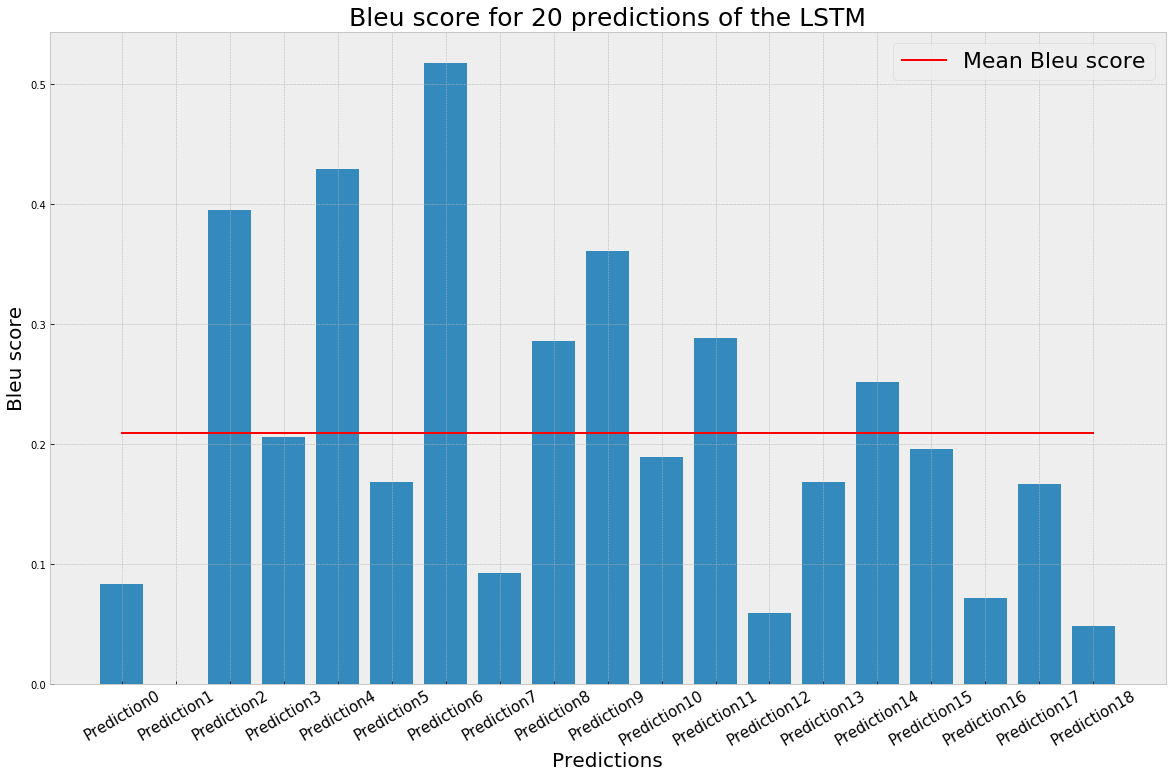

In [53]:
with plt.style.context('bmh'):
    plt.figure(figsize=(20,12))
    index = np.arange(19)
    label = ['Prediction{}'.format(i) for i in range(19)]
    plt.bar(index, bleu_lstm)
    plt.xlabel('Predictions', fontsize=20)
    plt.ylabel('Bleu score', fontsize=20)
    plt.xticks(np.arange(19), label, fontsize=15, rotation=30)
    plt.plot(index, [np.mean(bleu_lstm) for i in range(19)], color='r')
    plt.title('Bleu score for 20 predictions of the LSTM', size=25)
    plt.legend(['Mean Bleu score'], prop={'size': 22})
    plt.show()

Let's do the same for real Mozard sheet.

In [57]:
bleu_moz = []
text_file = open("unseen/us1.txt", "r")
lines = text_file.readlines()
moz_us = str(lines[0]).split()
while i<20*len(ref[0]):
    sheet = moz_us[i: i+len(ref[0])]
    bleu_moz.append(sentence_bleu([ref[i] for i in range(len(ref))], sheet, weights=(0, 1/12, 1/12, 1/6, 1/6, 1/6, 1/6, 1/12, 1/12)))
    i+=len(ref[0])

/jet/var/python/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 9-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/jet/var/python/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 8-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [69]:
bleu_lstm0 = []
bleu_lstm100 = []
for i in range(1):
    for j in range(10):
        for k in range(10):
            text_file = open("samples/result_epoch2{}{}_batch{}00.txt".format(j, k, i), "r")
            lines = text_file.readlines()
            lstm_pred = str(lines[0]).split()
            if i==0:
                bleu_lstm0.append(sentence_bleu([ref[i] for i in range(len(ref))], lstm_pred, weights=(0, 1/12, 1/12, 1/6, 1/6, 1/6, 1/6, 1/12, 1/12)))
            else:
                 bleu_lstm100.append(sentence_bleu([ref[i] for i in range(len(ref))], lstm_pred, weights=(0, 1/12, 1/12, 1/6, 1/6, 1/6, 1/6, 1/12, 1/12)))

/jet/var/python/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 7-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/jet/var/python/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 8-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/jet/var/python/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 9-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  war

In [8]:
text_file = open("gpt_samples/sample11.txt", "r")
lines = text_file.readlines()
gpt_pred = str(lines[0]).split()

In [ ]:
print('Cumulative 1-gram: %f' % sentence_bleu([ref for i in range(len(ref0))], gpt_pred, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu([ref for i in range(len(ref0))], gpt_pred, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu([ref for i in range(len(ref0))], gpt_pred, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu([ref for i in range(len(ref0))], gpt_pred, weights=(0.25, 0.25, 0.25, 0.25)))
print('Cumulative 5-gram: %f' % sentence_bleu([ref for i in range(len(ref0))], gpt_pred, weights=(1/5, 1/5, 1/5, 1/5, 1/5)))
print('Cumulative 6-gram: %f' % sentence_bleu([ref for i in range(len(ref0))], gpt_pred, weights=(1/6, 1/6, 1/6, 1/6, 1/6, 1/6)))
print('Cumulative 7-gram: %f' % sentence_bleu([ref for i in range(len(ref0))], gpt_pred, weights=(1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7)))
print('Cumulative 8-gram: %f' % sentence_bleu([ref for i in range(len(ref0))], gpt_pred, weights=(1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8)))
print('Cumulative 9-gram: %f' % sentence_bleu([ref for i in range(len(ref0))], gpt_pred, weights=(1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9)))

In [68]:
import zipfile
path_to_zip_file = 'samples.zip'
zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall()
zip_ref.close()

GPT gener